<a href="https://colab.research.google.com/github/Okocha76/DS-Unit-2-Applied-Modeling/blob/master/module3/LS_DS10_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
%%capture
import sys

!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Okocha76/Okocha76.github.io/master/euro_data.csv', sep=';', engine='python', encoding = "ISO-8859-1")

In [56]:
print(df.shape)
df.head()

(8010, 41)


,TIME,GEO,GEO_LABEL,AGEMOTH,MEDAGEMOTH,TOTFERRT,JAN,CNMIGRAT,CNMIGRATRT,DEATH,GBIRTHRT,GDEATHRT,GROW,GROWRT,LBIRTH,NATGROW,NATGROWRT,RT,PER_KM2,EUR_HAB_2GDP,EUR_HAB_EU,EUR_HAB_EU27_2019,MIO_EUR,MIO_NAC,MIO_PPS,MIO_PPS_EU27_2019,PPS_EU27_2019_HAB,PPS_HAB,PPS_HAB_EU,PPS_HAB_EU27_2019,EMP,SAL,EUR_HAB_2HHINC,ED0-2_25_64,ED3_4_25_64,ED3-8_25_64,ED5-8_25_64,ED0-2_30_34,ED3_4_30_34,ED3-8_30_34,ED5-8_30_34
0,2000,AT,Austria,28.7,29.4,1.35,8002186,17272,2.2,76780,9.8,9.6,18760,2.3,78268,1488,0.2,4.8,97.2,26700,134,145,213606.48,213606.48,206251.54,195513.50,24400,25700,130,133,3755.0,3243.7,18000,23.8,62.1,76.2,14.1,16.7,67.4,83.3,15.9
1,2001,AT,Austria,28.9,29.6,1.31,8020946,42003,5.2,74767,9.4,9.3,42694,5.3,75458,691,0.1,4.8,97.5,27400,133,143,220525.08,220525.08,207461.48,197764.57,24600,25800,125,128,3782.0,3265.1,18300,22.5,62.6,77.5,14.8,16.0,67.9,84.0,16.1
2,2002,AT,Austria,29.1,29.8,1.38,8063640,34365,4.3,76131,9.7,9.4,36633,4.5,78399,2268,0.3,4.1,98.0,28100,132,141,226735.22,226735.22,216432.92,206562.16,25600,26800,126,129,3778.4,3258.1,18500,21.7,62.7,78.3,15.7,15.9,66.9,84.1,17.2
3,2003,AT,Austria,29.2,29.9,1.36,8100273,42565,5.2,77209,9.5,9.5,42300,5.2,76944,-265,0.0,4.5,98.5,28600,132,140,231862.46,231862.46,221219.87,214271.17,26400,27200,126,130,3803.0,3275.3,18900,21.0,63.3,79.0,15.7,14.3,68.1,85.7,17.6
4,2004,AT,Austria,28.8,29.5,1.42,8142573,54110,6.6,74292,9.7,9.1,58786,7.2,78968,4676,0.6,4.5,99.1,29700,132,140,242348.26,242348.26,233343.6,225461.43,27600,28600,127,130,3826.8,3290.1,19700,20.2,61.8,79.8,18.0,13.5,65.6,86.5,20.9


In [64]:
train = df[df['TIME'] <= 2011]
val = df[(df['TIME'] > 2011) & (df['TIME'] < 2015)]
test = df[df['TIME'] >= 2015]

train.shape, val.shape, test.shape

((5340, 41), (1335, 41), (1335, 41))

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    # Feature selection is not final. Just a quick & dirty approach for now.

    X = X.drop(
        ['CNMIGRAT','DEATH','GROW','GROWRT','LBIRTH','NATGROW','NATGROWRT',
        'EUR_HAB_2GDP','EUR_HAB_EU27_2019','MIO_EUR','MIO_NAC','MIO_PPS',
        'MIO_PPS_EU27_2019','PPS_EU27_2019_HAB','PPS_HAB','PPS_HAB_EU27_2019',
        'SAL','EUR_HAB_2HHINC','ED0-2_25_64','ED3_4_25_64','ED3-8_25_64',
        'ED5-8_25_64','ED3-8_30_34','MEDAGEMOTH','PPS_HAB_EU','ED3_4_30_34']
        ,axis=1)
    
    X['JAN'] = pd.to_numeric(X['JAN'],errors='coerce')
    # X['JAN'] = X['JAN'].astype(int)
    X['TIME'] = X['TIME'].astype('category')

    # A bit of feature engineering. EMP_PC is percentage employed.
    X['EMP_PC'] = round((X['EMP'] * 100000)/X['JAN'],1)
    X['EMP_PC'] = X['EMP_PC'].replace(np.inf, np.nan)
    X = X.drop(['JAN','EMP'], axis=1)

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['AGEMOTH', 'ED0-2_30_34', 'ED5-8_30_34','EMP_PC',
                       'EUR_HAB_EU','GBIRTHRT','GDEATHRT','PER_KM2','RT',
                       'TOTFERRT']

    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    X = X.rename(columns={"ED0-2_30_34": "ED_LOW", "ED5-8_30_34": "ED_HIGH"})    

    # Make target feature categorical
    X["MIG_CAT"] = pd.cut(X["CNMIGRATRT"], [-np.inf, 0, 5, np.inf], labels=["low", "avg", "high"]).astype(np.object)
    X = X.drop(['CNMIGRATRT'], axis=1)

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [66]:
print(train.shape)
train.head(10)

(5340, 14)


,TIME,GEO,GEO_LABEL,AGEMOTH,TOTFERRT,GBIRTHRT,GDEATHRT,RT,PER_KM2,EUR_HAB_EU,ED_LOW,ED_HIGH,EMP_PC,MIG_CAT
0,2000,AT,Austria,28.7,1.35,9.8,9.6,4.8,97.2,134.0,16.7,15.9,46.9,avg
1,2001,AT,Austria,28.9,1.31,9.4,9.3,4.8,97.5,133.0,16.0,16.1,47.2,high
2,2002,AT,Austria,29.1,1.38,9.7,9.4,4.1,98.0,132.0,15.9,17.2,46.9,avg
3,2003,AT,Austria,29.2,1.36,9.5,9.5,4.5,98.5,132.0,14.3,17.6,46.9,high
4,2004,AT,Austria,28.8,1.42,9.7,9.1,4.5,99.1,132.0,13.5,20.9,47.0,high
5,2005,AT,Austria,29.0,1.41,9.5,9.1,4.2,99.8,132.0,13.9,20.7,47.2,high
6,2006,AT,Austria,29.2,1.41,9.4,9.0,3.6,100.3,131.0,13.6,21.1,47.7,avg
7,2007,AT,Austria,29.4,1.38,9.2,9.0,3.7,100.6,131.0,13.5,20.9,48.4,avg
8,2008,AT,Austria,29.5,1.42,9.3,9.0,3.7,100.9,135.0,12.8,21.9,49.2,avg
9,2009,AT,Austria,29.7,1.39,9.2,9.3,3.8,101.2,141.0,11.7,23.4,48.8,avg


In [0]:
train.describe()

,AGEMOTH,TOTFERRT,GBIRTHRT,GDEATHRT,RT,PER_KM2,EUR_HAB_EU,ED_LOW,ED_HIGH,EMP_PC
count,4553.000000,4553.000000,4726.000000,4688.000000,4535.000000,5063.000000,4274.000000,4501.000000,4517.000000,3799.000000
mean,29.331496,1.582546,10.762992,9.887991,4.932172,382.158681,94.124474,25.558454,27.560040,45.534483
std,1.337198,0.325652,2.568682,1.922314,2.980237,978.579942,61.314426,16.774505,11.283108,8.912151
min,24.300000,0.860000,6.400000,3.000000,0.200000,2.000000,6.000000,1.400000,2.900000,27.600000
25%,28.700000,1.350000,9.200000,8.900000,3.300000,69.000000,53.000000,14.400000,19.000000,41.000000
50%,29.400000,1.520000,10.400000,9.800000,4.000000,112.800000,92.000000,20.400000,26.800000,45.200000
75%,30.200000,1.810000,11.800000,10.900000,5.300000,265.700000,126.000000,31.900000,35.700000,48.700000
max,32.500000,3.940000,30.900000,19.800000,23.000000,10205.400000,716.000000,88.900000,77.500000,156.700000


In [0]:
# Generate Pandas Profiling Report and export to html

import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=True,
    correlations={
        'pearson': True,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
    )

profile_report.to_file(output_file="train.html")

## Baseline

In [67]:
y = train['MIG_CAT']
y.value_counts(normalize=True)

avg     0.397566
low     0.359925
high    0.242509
Name: MIG_CAT, dtype: float64

Baseline prediction: majority class (avg) occurs with 40% frequency.

## Model

In [0]:
# Arrange data into X features matrix and y target vector
target = 'MIG_CAT'
features = train.columns.drop([target, 'GEO_LABEL'])

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [69]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6217228464419475


## Feature Importances

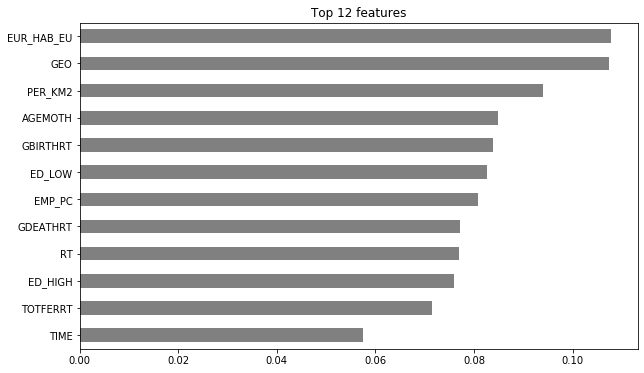

In [70]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 12
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Drop-Column Importance

In [71]:
column  = 'EUR_HAB_EU'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without EUR_HAB_EU: 0.5865168539325842
Validation Accuracy with EUR_HAB_EU: 0.6217228464419475
Drop-Column Importance for EUR_HAB_EU: 0.03520599250936329


In [72]:
column  = 'GEO'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without GEO: 0.5797752808988764
Drop-Column Importance for GEO: 0.04194756554307111


In [73]:
column  = 'PER_KM2'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without PER_KM2: 0.6232209737827715
Drop-Column Importance for PER_KM2: -0.001498127340823996


## Permutation Importance

In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [75]:
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [76]:
!pip install eli5

     |████████████████████████████████| 112kB 9.6MB/s 


In [77]:
import eli5
from eli5.sklearn import PermutationImportance

# 1. Calculate permutation importances
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [78]:
feature_names = X_val.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 2. Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0867 ± 0.0131,EUR_HAB_EU
0.0463 ± 0.0077,GEO
0.0452 ± 0.0077,EMP_PC
0.0424 ± 0.0081,GDEATHRT
0.0303 ± 0.0045,ED_LOW
0.0256 ± 0.0078,AGEMOTH
0.0249 ± 0.0122,ED_HIGH
0.0202 ± 0.0138,PER_KM2
0.0157 ± 0.0079,TOTFERRT
0.0151 ± 0.0106,RT


## Feature selection

In [0]:
# In this case just an elaborate way to drop 'TIME'.

minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [80]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6374531835205992


In [81]:
permuter.feature_importances_ - permuter.feature_importances_std_ > 0

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

## Gradient Boosting

In [82]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GEO'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'GEO', 'data_type': dtype('O'),
                                          'mapping': AT        1
AT1       2
AT11      3
AT12      4
AT13      5
       ... 
UKM8    442
UKM9    443
UKN     444
UKN0    445
NaN      -2
Length: 446, dtype: int64}],
                                return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5...oster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nth

In [83]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.5760299625468165


In [84]:
# fit_transfom on train, transform on val
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 trees, depends on early stopping
    max_depth=5,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.4,  # try higher learning rate
    min_child_weight=0.5,  
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='merror', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

[0]	validation_0-merror:0.290637	validation_1-merror:0.448689
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.255243	validation_1-merror:0.427715
[2]	validation_0-merror:0.244382	validation_1-merror:0.433708
[3]	validation_0-merror:0.223034	validation_1-merror:0.433708
[4]	validation_0-merror:0.208801	validation_1-merror:0.418727
[5]	validation_0-merror:0.210487	validation_1-merror:0.405993
[6]	validation_0-merror:0.202622	validation_1-merror:0.4
[7]	validation_0-merror:0.189888	validation_1-merror:0.400749
[8]	validation_0-merror:0.183521	validation_1-merror:0.411985
[9]	validation_0-merror:0.178464	validation_1-merror:0.411985
[10]	validation_0-merror:0.167978	validation_1-merror:0.416479
[11]	validation_0-merror:0.165918	validation_1-merror:0.414232
[12]	validation_0-merror:0.161798	validation_1-merror:0.408989
[13]	validation_0-merror:0.156929

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=5,
              min_child_weight=0.5, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

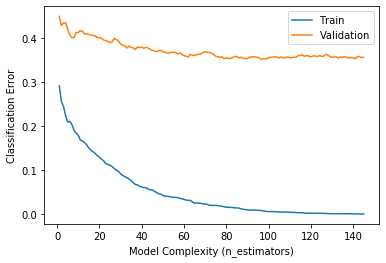

In [85]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
# plt.ylim((0.35, 0.4)) # Zoom in
plt.legend();